In [31]:
import os
from langchain_core.messages import HumanMessage, AnyMessage
from langchain_core.prompts import PromptTemplate
from langchain_groq import ChatGroq
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from typing import List, Annotated, TypedDict
from operator import add
from langchain_community.tools import TavilySearchResults
from langchain.document_loaders import WikipediaLoader
from langchain_core.output_parsers import StrOutputParser
from IPython.display import display, Image

In [32]:
load_dotenv()

True

In [33]:
model = ChatGroq(model = "llama-3.1-8b-instant",temperature = 0)

In [34]:
class State(TypedDict):
    question:str
    answer:str
    context:Annotated[List[str],add]
    
def web_search(state:State):
    question = state.get("question","")
    tavilly_api = TavilySearchResults()
    web_search = "/n".join([cn['content'] for cn in tavilly_api.invoke(question,tavilly_api = os.getenv("TAVILY_API_KEY"))])
    return {"context":[web_search]}

def wikipedia_search(state:State):
    question = state.get("question","")
    wikipedia = WikipediaLoader(question,load_max_docs=2).load()
    result = "/n".join([doc.metadata['summary'] for doc in wikipedia])
    return {"context":[result]}

def doc_combine(state:State):
    question = state.get("question")
    reference = "\n".join(state['context'])
    
    prompt = PromptTemplate(
        template = "Using Web Search results and Wikipedia article as reference:\n {reference}\n\n answer the following question:- {question} ",
        input_variables=['reference','question']
    )
    
    parser = StrOutputParser()
    
    chain = prompt | model | parser
    
    result = chain.invoke({"question":question,"reference":reference})
    
    return {"answer":result}

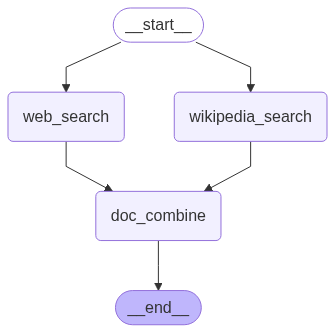

In [35]:
builder = StateGraph(State)
builder.add_node("web_search",web_search)
builder.add_node("wikipedia_search",wikipedia_search)
builder.add_node("doc_combine",doc_combine)

builder.add_edge(START,"web_search")
builder.add_edge(START,"wikipedia_search")
builder.add_edge("wikipedia_search","doc_combine")
builder.add_edge("web_search","doc_combine")

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
graph.invoke({"question":"Who is Narendra Modi ?"})

{'question': 'Who is Narendra Modi ?',
 'answer': "Narendra Modi is the current Prime Minister of India. He was born on September 17, 1950, in Vadnagar, Gujarat, India. He is a senior leader of the Bharatiya Janata Party (BJP), a right-wing political party in India. Modi has served as the Prime Minister of India since May 2014 and has been re-elected for a second and third term in 2019 and 2024, respectively.\n\nPrior to becoming the Prime Minister, Modi served as the Chief Minister of Gujarat state in western India from 2001 to 2014. He is known for his dynamic leadership and development-focused agenda, and has been a key figure in Indian politics for several decades.\n\nModi is also known by various names, including NaMo, which is a widely used abbreviation derived from the first two letters of his first and last names. He is a member of the Rashtriya Swayamsevak Sangh (RSS) and has been an active member of the organization for many years.\n\nModi's personal life is also notable, as 

In [37]:
graph.invoke({"question":"How to control sex Urges ?"})

{'question': 'How to control sex Urges ?',
 'answer': "Based on the provided information, here are some tips to control sex urges:\n\n1. **Identify the triggers**: Understand what triggers your sex urges and try to avoid those situations.\n2. **Seek immediate solutions**: Engage in activities that distract you from your sex urges, such as going for a walk, talking to a friend or coworker, or creating a to-do list.\n3. **Practice stress-relieving techniques**: Regular exercise, creative hobbies, or meditation can help reduce stress and manage sex urges.\n4. **Avoid pornography**: Limit or avoid exposure to explicit content that can fuel sex urges.\n5. **Consider abstaining from drugs or alcohol**: Substance use can increase the likelihood of engaging in risky sexual behavior.\n6. **Talk to others who can help**: Share your concerns with a trusted friend, partner, or mental health professional.\n7. **Set boundaries**: Establish clear boundaries with yourself and others to maintain health